In [1]:
import pandas as pd


df = pd.read_csv("input-eeg.csv")

In [2]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = df['eyeDetection']

X = df.drop(
    ['eyeDetection'],
    axis=1
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV

# Extra Trees optimizacija
print("\n--- Extra Trees optimizacija ---")
et_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

et = ExtraTreesClassifier(random_state=42, n_jobs=1)
et_grid = RandomizedSearchCV(et, et_param_grid, n_iter=20, cv=5, scoring='accuracy', 
                              random_state=42, n_jobs=1, verbose=1)
et_grid.fit(X_train, y_train)

print(f"Najbolji parametri: {et_grid.best_params_}")
print(f"Najbolja CV tačnost: {et_grid.best_score_*100:.2f}%")

et_best = et_grid.best_estimator_
et_pred = et_best.predict(X_test)


--- Extra Trees optimizacija ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Najbolji parametri: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Najbolja CV tačnost: 94.24%


100%|===================| 5983/5992 [08:18<00:00]        

SHAP Summary Plot - Random Forest


<Figure size 1200x800 with 0 Axes>

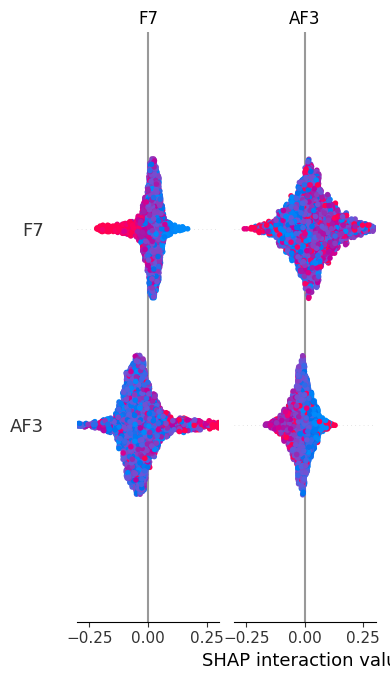

<Figure size 640x480 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt
import shap

explainer_rf = shap.Explainer(et_best, X_train)
shap_values_rf = explainer_rf(X_test, check_additivity=False)

print("SHAP Summary Plot - Random Forest")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf)
plt.tight_layout()
plt.show()

In [5]:
from matplotlib import pyplot as plt
import shap

et = ExtraTreesClassifier(random_state=42, n_jobs=1)
et.fit(X_train, y_train)

explainer = shap.Explainer(et, X_train)
shap_values = explainer(X_test, check_additivity=False)

100%|===================| 5969/5992 [04:09<00:00]        

SHAP Summary Plot - Extra Trees


<Figure size 1200x800 with 0 Axes>

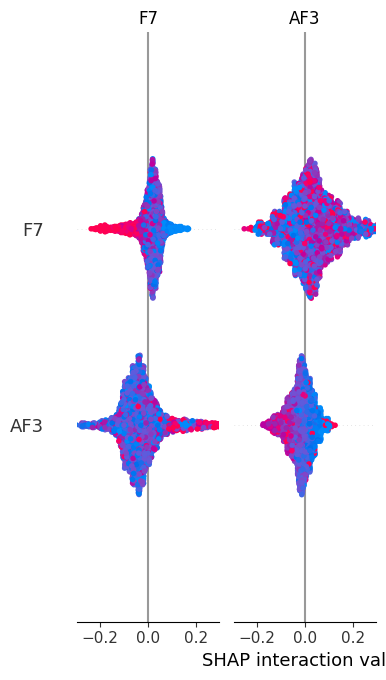

<Figure size 640x480 with 0 Axes>

In [6]:
print("SHAP Summary Plot - Extra Trees")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values)
plt.tight_layout()
plt.show()

In [11]:
from matplotlib import pyplot as plt
import shap
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

explainer = shap.Explainer(knn.predict_proba, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer:  10%|█         | 313/2996 [08:28<1:13:51,  1.65s/it]


KeyboardInterrupt: 

 99%|===================| 5962/5992 [02:15<00:00]        

SHAP shape: (2996, 14, 2)
Classes: [0 1]


/var/folders/vh/1d95__px2rng7y1qswnzkpdc0000gn/T/ipykernel_81559/2296340512.py:44: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


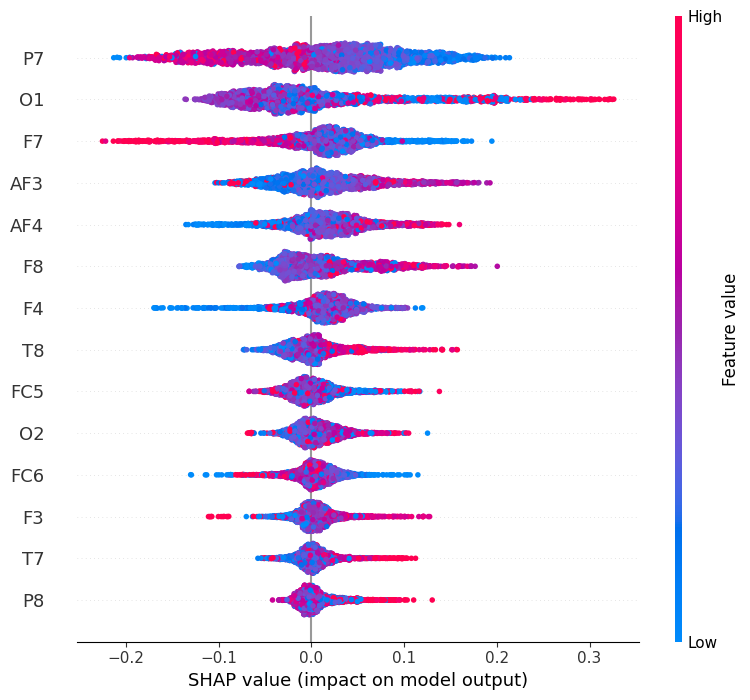

In [ ]:
import shap

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

explainer_rf = shap.Explainer(rf, X_train)
 
sv = explainer_rf(X_test, check_additivity=False)
 
print("SHAP shape:", sv.values.shape)
print("Classes:", rf.classes_)

sv_pos = sv[..., 1]

plt.figure(figsize=(14, 10))
shap.summary_plot(sv_pos, X_test, max_display=X_test.shape[1], show=False)
plt.tight_layout()
plt.show()

1️⃣ Šta ovaj dijagram uopšte predstavlja
Ovo je globalno objašnjenje Random Forest modela:
Kako svaka EEG elektroda (feature) utiče na izlaz modela, preko svih uzoraka
Svaka tačkica = jedan uzorak (sample)
Svaki red = jedan feature (elektroda)
2️⃣ Y-osa: rangiranje feature-a po važnosti
Feature-i su sortirani po prosečnoj |SHAP| vrednosti (od vrha ka dnu):
👉 P7 je najuticajniji
👉 P8 je najmanje uticajan
To znači:
model se najviše oslanja na P7
a najmanje na P8
Ovo je bolje od feature_importances_ jer:
pokazuje pravac uticaja
pokazuje distribuciju, ne samo prosečnu važnost

X-osa kaže:
Koliko taj feature gura predikciju ka pozitivnoj ili negativnoj klasi
SHAP > 0 → povećava verovatnoću pozitivne klase
SHAP < 0 → gura ka negativnoj klasi
0 → nema uticaja
Primer:
P7 ide od ~-0.25 do +0.30 → jak i dvosmeran uticaj
P8 je skupljen oko 0 → slab uticaj
 
